### 18. MONAI deep learning affine registration and non-linear with ITKElastix

This notebook shows to perform affine registration with MONAI, convert the resulting affine parameters to a format compatible with Elastix and then further refine the result using Elastix b-splines.

In [1]:
import os
import itk
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from monai.utils import set_determinism
from monai.transforms import Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityRangeD, Rotate90D, Rand2DElasticD
from monai.data import CacheDataset, ITKReader, DataLoader, MetaTensor, itk_torch_bridge
from monai.config import USE_COMPILED
from monai.networks.nets import DenseNet
from monai.networks.nets.regunet import AffineHead
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset
from torch.nn import MSELoss

# Set the random seed to a fixed number, just to ensure that the example always produces the same result 
set_determinism(42)

if torch.cuda.is_available():
    device = "cuda:0"
    max_epochs = 100
else:
    # For the case of running the model in the CPU, we restrict the number of epochs so that it runs in considerable time.
    # However, the final results might look sub-optimal.
    device = "cpu"
    max_epochs=3

print("Device: ", device)

Device:  cuda:0


### Dataset

After downloading the MedNISTDataset, we keep only the x-ray hand images dataset and create pairs of fixed and moving images by applying random affine and grid transforms to fixed images.

In [2]:
# Download MedNISTDataset
root_dir = './'
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, transform=None)

# Keep only the hand x-rays
hands = [os.path.join(root_dir, item["image"]) for item in train_data.data if item["label"]==4] # label 4 is for xray hands

# Create training dictionary with only a subset of the whole data
training_datadict = [
    {"fixed_hand": hand, "moving_hand": hand}
    for hand in hands[:500]
]

2023-07-28 16:35:43,039 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-07-28 16:35:43,041 - INFO - File exists: MedNIST.tar.gz, skipped downloading.
2023-07-28 16:35:43,043 - INFO - Non-empty folder exists in MedNIST, skipped extracting.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:00<00:00, 84379.40it/s]


In [3]:
train_transforms = Compose(
    [
        LoadImageD(keys=["fixed_hand", "moving_hand"], image_only=True),
        EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
        ScaleIntensityRangeD(keys=["fixed_hand", "moving_hand"],
                             a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
        Rotate90D(keys=["fixed_hand", "moving_hand"], k=-1),
        Rand2DElasticD(keys=["moving_hand"], 
                    spacing=4.0,
                    magnitude_range=(0, 1),
                    prob=1.0, 
                    rotate_range=(-0.2, 0.2), 
                    shear_range=(-0.05, 0.05), 
                    translate_range=(-15, 15),
                    padding_mode="zeros"),        
    ]
)

In [4]:
dataset = CacheDataset(data=training_datadict, transform=train_transforms)
dataloader = DataLoader(dataset=dataset, batch_size=16, shuffle=True)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 246.09it/s]


### Deep learning registration model

In [5]:
# Create model
class AffineRegistrationModel(torch.nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.densenet = DenseNet(
            spatial_dims=2, 
            in_channels=2, 
            out_channels=6, 
            init_features=16, 
            growth_rate=6,
            block_config=(6, 12, 18)).to(device)
        
        # Init fully connected layer
        self.densenet.class_layers.out.weight.data.zero_()
        self.densenet.class_layers.out.bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        # Grid
        self.grid = AffineHead.get_reference_grid(image_size).to(device=device)
        
    def affine_transform(self, theta):
        grid_padded = torch.cat([self.grid, torch.ones_like(self.grid[:1])])
        grid_warped = torch.einsum("qij,bpq->bpij", grid_padded, theta.reshape(-1, 2, 3))
        return grid_warped
    
    def forward(self, x):
        theta = self.densenet(x)
        out = self.affine_transform(theta) - self.grid
        return out, theta

model = AffineRegistrationModel(image_size=(64, 64))
criterion = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

if USE_COMPILED:
    # Use experimental resampler under the hood 
    # (see: https://github.com/Project-MONAI/MONAI/discussions/4505#discussioncomment-2953180)
    warp_layer = Warp(3, "border").to(device)
else:
    # Using the standard MONAI resampler
    warp_layer = Warp("bilinear", "border").to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f"The model has {count_parameters(model)} trainable parameters.")

The model has 127744 trainable parameters.


monai.networks.blocks.Warp: Using PyTorch native grid_sample.


### Training loop

In [6]:
epoch_loss_values = []
model.train()

for epoch in tqdm(range(max_epochs)):
    epoch_loss = 0
    for i, batch_data in enumerate(dataloader):
        optimizer.zero_grad()

        fixed = batch_data["fixed_hand"].to(device)
        pre_aligned = batch_data["moving_hand"].to(device)
    
        ddf, theta = model(torch.cat((pre_aligned, fixed), dim=1))
        pred_image = warp_layer(pre_aligned, ddf)

        loss = criterion(pred_image, fixed)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*fixed.shape[0]

    epoch_loss /= len(dataset)
    epoch_loss_values.append(epoch_loss)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:57<00:00,  4.78s/it]


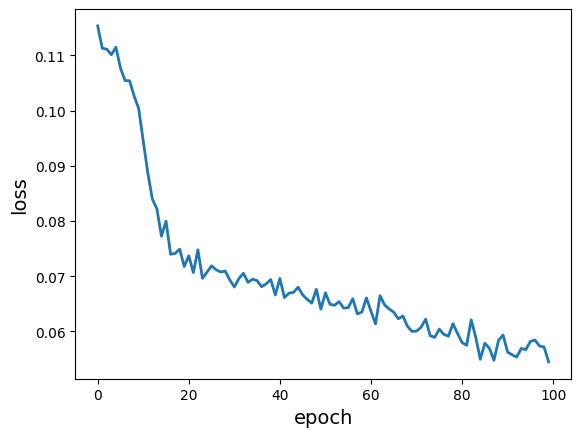

In [7]:
plt.plot(epoch_loss_values, linewidth=2)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.show()

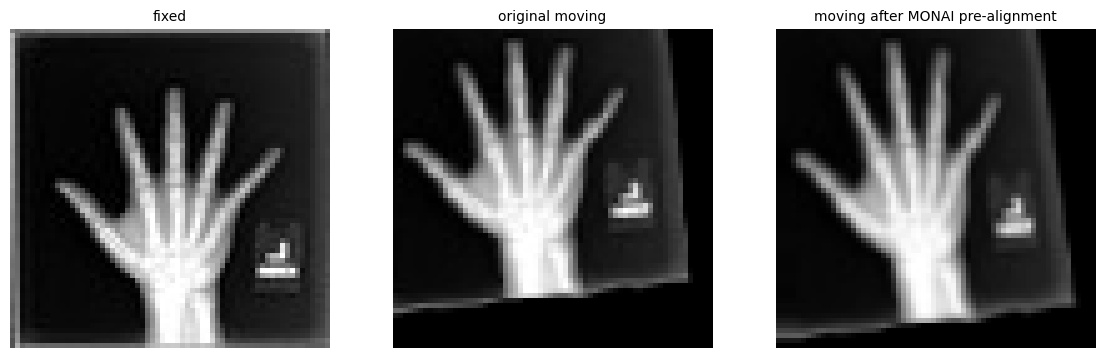

In [8]:
# Show examples of the pre-alignment using MONAI
ind = 2
fixed = batch_data['fixed_hand'][ind].squeeze().numpy()
moving = batch_data['moving_hand'][ind].squeeze().numpy()
aligned = pred_image[ind].squeeze().detach().cpu().numpy()

fig = plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.imshow(fixed.squeeze(), cmap='gray')
plt.title('fixed', fontsize=10)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(moving.squeeze(), cmap='gray')
plt.title('original moving', fontsize=10)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(aligned.squeeze(), cmap='gray')
plt.title('moving after MONAI pre-alignment', fontsize=10)
plt.axis('off')
plt.show()

### Convert MONAI affine parameters to ITK Affine Transform

We convert the computed MONAI affine transform to an ITK transform using the utility function `monai.data.itk_torch_bridge`, and then pass it as initial transform to itk-elastix (requires >0.17.3 version)

In [9]:
# Convert the output of the model to a 3x3 affine matrix
monai_affine_matrix = torch.eye(3, dtype=torch.float64)
monai_affine_matrix[:2, :] = theta.reshape(-1, 2, 3).detach().cpu()[ind]

# Convert the tensors to ITK images. NOTE: We use the util function metatensor_to_itk_image() because
# it also does the necessary transposition of the images.
fixed_image = itk_torch_bridge.metatensor_to_itk_image(MetaTensor(batch_data['fixed_hand'][ind]))
moving_image = itk_torch_bridge.metatensor_to_itk_image(MetaTensor(batch_data['moving_hand'][ind]))

# Convert MONAI affine matrix to ITK
matrix, translation = itk_torch_bridge.monai_to_itk_affine(moving_image, affine_matrix=monai_affine_matrix)

# Affine transform
itk_transform = itk.AffineTransform[itk.D, moving_image.ndim].New()

# Set center
itk_transform.SetCenter(itk_torch_bridge.get_itk_image_center(moving_image))

# Set matrix and translation
itk_transform.SetMatrix(itk.matrix_from_array(matrix))
itk_transform.Translate(translation)

print(itk_transform)

AffineTransform (00000211A505A5F0)
  RTTI typeinfo:   class itk::AffineTransform<double,2>
  Reference Count: 1
  Modified Time: 38
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    1.05321 0.0656178 
    0.00755561 0.920415 
  Offset: [-3.6547, 2.27981]
  Center: [31.5, 31.5]
  Translation: [0.0883499, 0.0108792]
  Inverse: 
    0.949965 -0.0677244 
    -0.00779819 1.08702 
  Singular: 0



### Refine MONAI result with Elastix registration

In [10]:
# B-spline parameter object
parameter_object = itk.ParameterObject()
parameter_map = parameter_object.GetDefaultParameterMap('bspline')
parameter_object.AddParameterMap(parameter_map)

result_image, _ = itk.elastix_registration_method(fixed_image, 
                                                  moving_image, 
                                                  parameter_object=parameter_object,
                                                  initial_transform=itk_transform,
                                                  log_to_console=False)

result = np.asarray(result_image).T

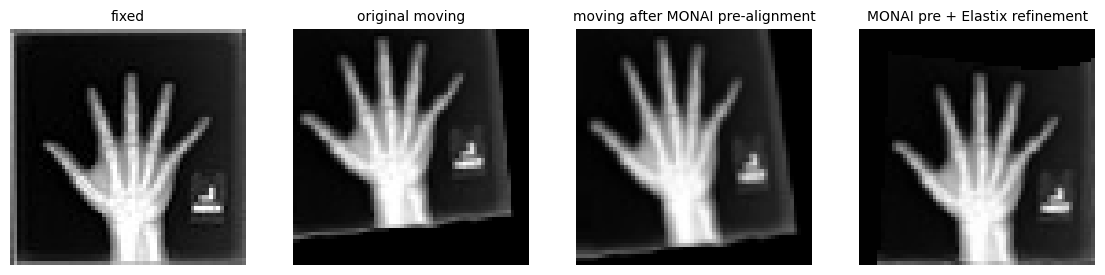

In [11]:
# Show previous results together with final result from Elastix
fig = plt.figure(figsize=(14, 6))
plt.subplot(1, 4, 1)
plt.imshow(fixed.squeeze(), cmap='gray')
plt.title('fixed', fontsize=10)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(moving.squeeze(), cmap='gray')
plt.title('original moving', fontsize=10)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(aligned.squeeze(), cmap='gray')
plt.title('moving after MONAI pre-alignment', fontsize=10)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(result, cmap='gray')
plt.title('MONAI pre + Elastix refinement', fontsize=10)
plt.axis('off')
plt.show()

In [12]:
# Perform numerical comparison using the mean square error (MSE)
MSE_moving = criterion(torch.tensor(fixed).unsqueeze(0), torch.tensor(moving).unsqueeze(0))
MSE_monai_aligned = criterion(torch.tensor(fixed).unsqueeze(0), torch.tensor(aligned).unsqueeze(0))
MSE_monai_and_elastix = criterion(torch.tensor(fixed).unsqueeze(0), torch.tensor(result).unsqueeze(0))

print("MSE moving: {:.4f}".format(MSE_moving))
print("MSE MONAI: {:.4f}".format(MSE_monai_aligned))
print("MSE MONAI+Elastix: {:.4f}".format(MSE_monai_and_elastix))

MSE moving: 0.1083
MSE MONAI: 0.0832
MSE MONAI+Elastix: 0.0129


### Conclusion

We observe that the MSE after the Elastix refinement is lower than when registering only using MONAI. The images above indicate the same result but in a qualitative manner.